In [16]:
"""
Sample from the trained model with PyTorch
"""
import json
from contextlib import nullcontext
import torch
import os, sys
from pathlib import Path

# Support absolute imports for a standalone script
sys.path.insert(0, Path.cwd().parent.as_posix())


from model import ModelArgs, Transformer, softmax_sum
from tokenizer import Tokenizer
from tinystories import get_tokenizer_model_path

# -----------------------------------------------------------------------------
start = "" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
max_new_tokens = 25 # number of tokens generated in each sample
temperature = 0 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 300 # retain only the top_k most likely tokens, clamp others to have 0 probability
tokenizer = "" # override the tokenizer model path
seed = 1337
device = 'cuda' if torch.cuda.is_available() else 'cpu' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
dtype = "float16"
compile = False # use PyTorch 2.0 to compile the model to be faster

softmax0_run = 'softmax0-15m-2023_08_26_00_08_49'
softmax1_run = 'softmax1-15m-2023_08_25_11_47_04'
softmax1_110m_run = 'artifacts/l83srejz_model:v49'
# -----------------------------------------------------------------------------

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

def load_model(out_dir):
    # init from a model saved in a specific directory
    checkpoint_dict = torch.load(f"{out_dir}/ckpt.pt", map_location=device)
    # del flash if exists
    if 'flash' in checkpoint_dict['model_args']:
        del checkpoint_dict['model_args']['flash']
    # softmax -> softmax1 in model_args
    if 'softmax' in checkpoint_dict['model_args']:
        checkpoint_dict['model_args']['softmax1'] = checkpoint_dict['model_args']['softmax']
        del checkpoint_dict['model_args']['softmax']
    gptconf = ModelArgs(**checkpoint_dict['model_args'])
    model = Transformer(gptconf)
    state_dict = checkpoint_dict['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict, strict=False)

    model.eval()
    model.to(device)
    if compile:
        print("Compiling the model...")
        model = torch.compile(model) # requires PyTorch 2.0 (optional)
    
    return model

def load_tokenizer(out_dir):
    # load the tokenizer
    with open(f"{out_dir}/config.json", 'r') as f:
        config = json.load(f)
    vocab_source = config.get("vocab_source", "llama2")
    vocab_size = config['vocab_size']
    if tokenizer:
        # a specific tokenizer is provided, use it
        tokenizer_model = tokenizer
    else:
        # let's try to find the tokenizer model automatically. bit gross here...
        query_vocab_size = 0 if vocab_source == "llama2" else vocab_size
        tokenizer_model = get_tokenizer_model_path(vocab_size=query_vocab_size)
    enc = Tokenizer(tokenizer_model='../tokenizer.model')
    return enc

model_softmax0 = load_model(f'../out/{softmax0_run}')
model_softmax1 = load_model(f'../out/{softmax1_run}')
model_softmax1_110m = load_model(f'../{softmax1_110m_run}')
enc = load_tokenizer(f'../out/{softmax0_run}')

def encode_prompt(start):
    if start.startswith('FILE:'):
        with open(start[5:], 'r', encoding='utf-8') as f:
            start = f.read()
    start_ids = enc.encode(start, bos=True, eos=False)
    x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
    return x

# run generation
@torch.no_grad()
def generate(model=model_softmax1_110m, prompt=start, max_new_tokens=max_new_tokens, temperature=temperature, top_k=top_k):
    x = encode_prompt(prompt)
    with ctx:
        y = model.generate(x, max_new_tokens, temperature, top_k)
        return enc.decode(y.tolist())[0]

In [17]:
import torch.nn.functional as F

def compute_perplexity(prompt, model=model_softmax1_110m, max_new_tokens=max_new_tokens, temperature=temperature, top_k=top_k):
	"""
	Compute the perplexity given the logits of generated tokens and their corresponding indices.
	"""
	x = encode_prompt(prompt)
	idx, logits = model.generate(x, max_new_tokens=max_new_tokens, temperature=temperature, top_k=top_k, return_logits=True)
	probs = F.softmax(logits, dim=-1)
	actual_probs = torch.gather(probs, -1, idx.unsqueeze(-1)[:, x.shape[1]:, :])
	neg_log_probs = -torch.log(actual_probs)
	return torch.exp(torch.mean(neg_log_probs)).item()

In [18]:
generate(model_softmax1_110m, "Sally sold seashells by the")
S = torch.stack(softmax_sum)
S.shape

RuntimeError: stack expects each tensor to be equal size, but got [12, 106] at entry 0 and [12, 9] at entry 9

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from functools import partial

def attnsum_layer_heatmap(data, layer_num, ax, vmin=0.5, vmax=1.0):
	"""
	Plot a heatmap for the specified layer's softmax attention score sums.
	
	Parameters:
	- data: 3D numpy array containing the attention scores.
	- layer_num: Layer number to plot.
	- ax: Matplotlib axis object to plot on.
	- vmin, vmax: Color scale limits.
	"""
	ax.imshow(data[layer_num], aspect='auto', cmap='inferno', vmin=vmin, vmax=vmax)
	ax.set_title(f'Layer {layer_num+1} Heatmap')
	ax.set_ylabel('Attention Heads')
	ax.set_xlabel('Seq Length')
	ax.figure.colorbar(mappable=ax.get_images()[0], ax=ax)

def attnsum_layer_histogram(data, layer_num, ax):
	"""
	Plot a histogram for the specified layer.
	
	Parameters:
	- data: 3D numpy array containing the attention scores.
	- layer_num: Layer number to plot.
	- ax: Matplotlib axis object to plot on.
	- bin_edges: Bin edges for the histogram.
	"""
	ax.hist(data[layer_num].flatten(), bins=50, color='cornflowerblue', alpha=0.8, log=True)
	ax.set_title(f'Layer {layer_num+1} Attention Distribution')
	ax.set_xlabel('Attention Score Sum')
	ax.set_ylabel('Frequency (Log)')

def attnsum_layer(S, layer_num):
	"""
	Wrapper function to plot both heatmap and histogram for a specified layer.
	
	Parameters:
	- layer_num: Layer number to plot.
	"""
	fig, axes = plt.subplots(1, 2, figsize=(15, 5))
	
	# Plot heatmap on the first axis
	attnsum_layer_heatmap(S, layer_num, axes[0])
	
	# Plot histogram on the second axis
	attnsum_layer_histogram(S, layer_num, axes[1])
	
	plt.tight_layout()
	plt.show()

def interactive_attnsum_layer(S):
	"""
	Plot softmax1's attention score sums, per layer, interactively with iPython sliders.

	Parameters:
	- S (Tensor): Attention score sums.
	"""
	# Create an interactive slider for layer selection
	print(S.shape)
	layer_slider = widgets.IntSlider(value=0, min=0, max=S.shape[0]-1, step=1, description='Layer Num:')
	plot = widgets.interactive_output(partial(attnsum_layer, S), {'layer_num': layer_slider})

	interactive_plot = widgets.VBox([layer_slider, plot])

	return interactive_plot

def rolling_window(data, window_size):
    """Apply a rolling window average to data."""
    weights = np.repeat(1.0, window_size) / window_size
    return np.convolve(data, weights, 'valid')

def attnsum_all(softmax_data):
	"""
	Plot a heatmap and histogram for the concatenated activations across all layers.

	Parameters:
	- softmax_data: 3D numpy array containing the activations.
	"""
	# Concatenate activations along the attention heads dimension
	concat_activations = softmax_data.reshape(-1, softmax_data.shape[-1])
	num_heads = softmax_data.shape[1]

	# Min of activations over seq
	min_activations = torch.min(softmax_data, dim=1).values

	fig, axes = plt.subplots(1, 3, figsize=(24, 16))

	# Plot heatmap for concatenated activations
	axes[0].imshow(concat_activations, aspect='auto', cmap='inferno')
	axes[0].set_title('Attention Score Sums')
	axes[0].set_ylabel('Nth Head of Mth Layer')
	axes[0].set_xlabel('Seq Length')
	axes[0].figure.colorbar(mappable=axes[0].get_images()[0], ax=axes[0])

	# Plot histogram for all flattened values
	axes[1].hist(min_activations.flatten(), bins=15, color='cornflowerblue', edgecolor='black')
	axes[1].set_title('Smallest Attention Score Sum over Sequence')
	axes[1].set_xlabel('Min Attention Score / Head / Layer')
	axes[1].set_ylabel('Frequency')

	# Find bottom 10% of mean values
	threshold = torch.quantile(concat_activations.mean(dim=1), 0.1)
	
	# Plot multiline plot for concatenated activations
	bottom_activations = []
	for i, line in enumerate(concat_activations):
		if line.mean() <= threshold:
			axes[2].plot(rolling_window(line.numpy(), 4), label=f'Head {i//num_heads} Layer {i%num_heads}', alpha=0.5)
			bottom_activations.append(line)
	bottom_activations = torch.stack(bottom_activations)

	axes[2].plot(rolling_window(bottom_activations.mean(dim=0).numpy(), 4), label='Mean', color='black', linewidth=2)

	axes[2].set_title('Attention Score Sum over Sequence (Bottom 10% Mean)')
	axes[2].set_xlabel('Seq Length')
	axes[2].set_ylabel('Attention Score Sum (Smoothened)')
	axes[2].legend()


	plt.tight_layout()
	plt.show()

 idjfkldsfj klsdjfkl sfj ksdf idjfkldsfj klsdjfkl sfj ksdf idjfkldsfj klsdjfkl sfj ksdf idjfkldsfj klsdjfkl sfj ksdf idjfkldsfj klsdjfkl sfj ksdf and Lily kicks the ball. Lily kicks the ball with her foot and Max k
torch.Size([9, 12, 106])
Token Count: 106
Perplexity: 3.4764
Overall Min: 0.1966
torch.Size([9, 12, 106])


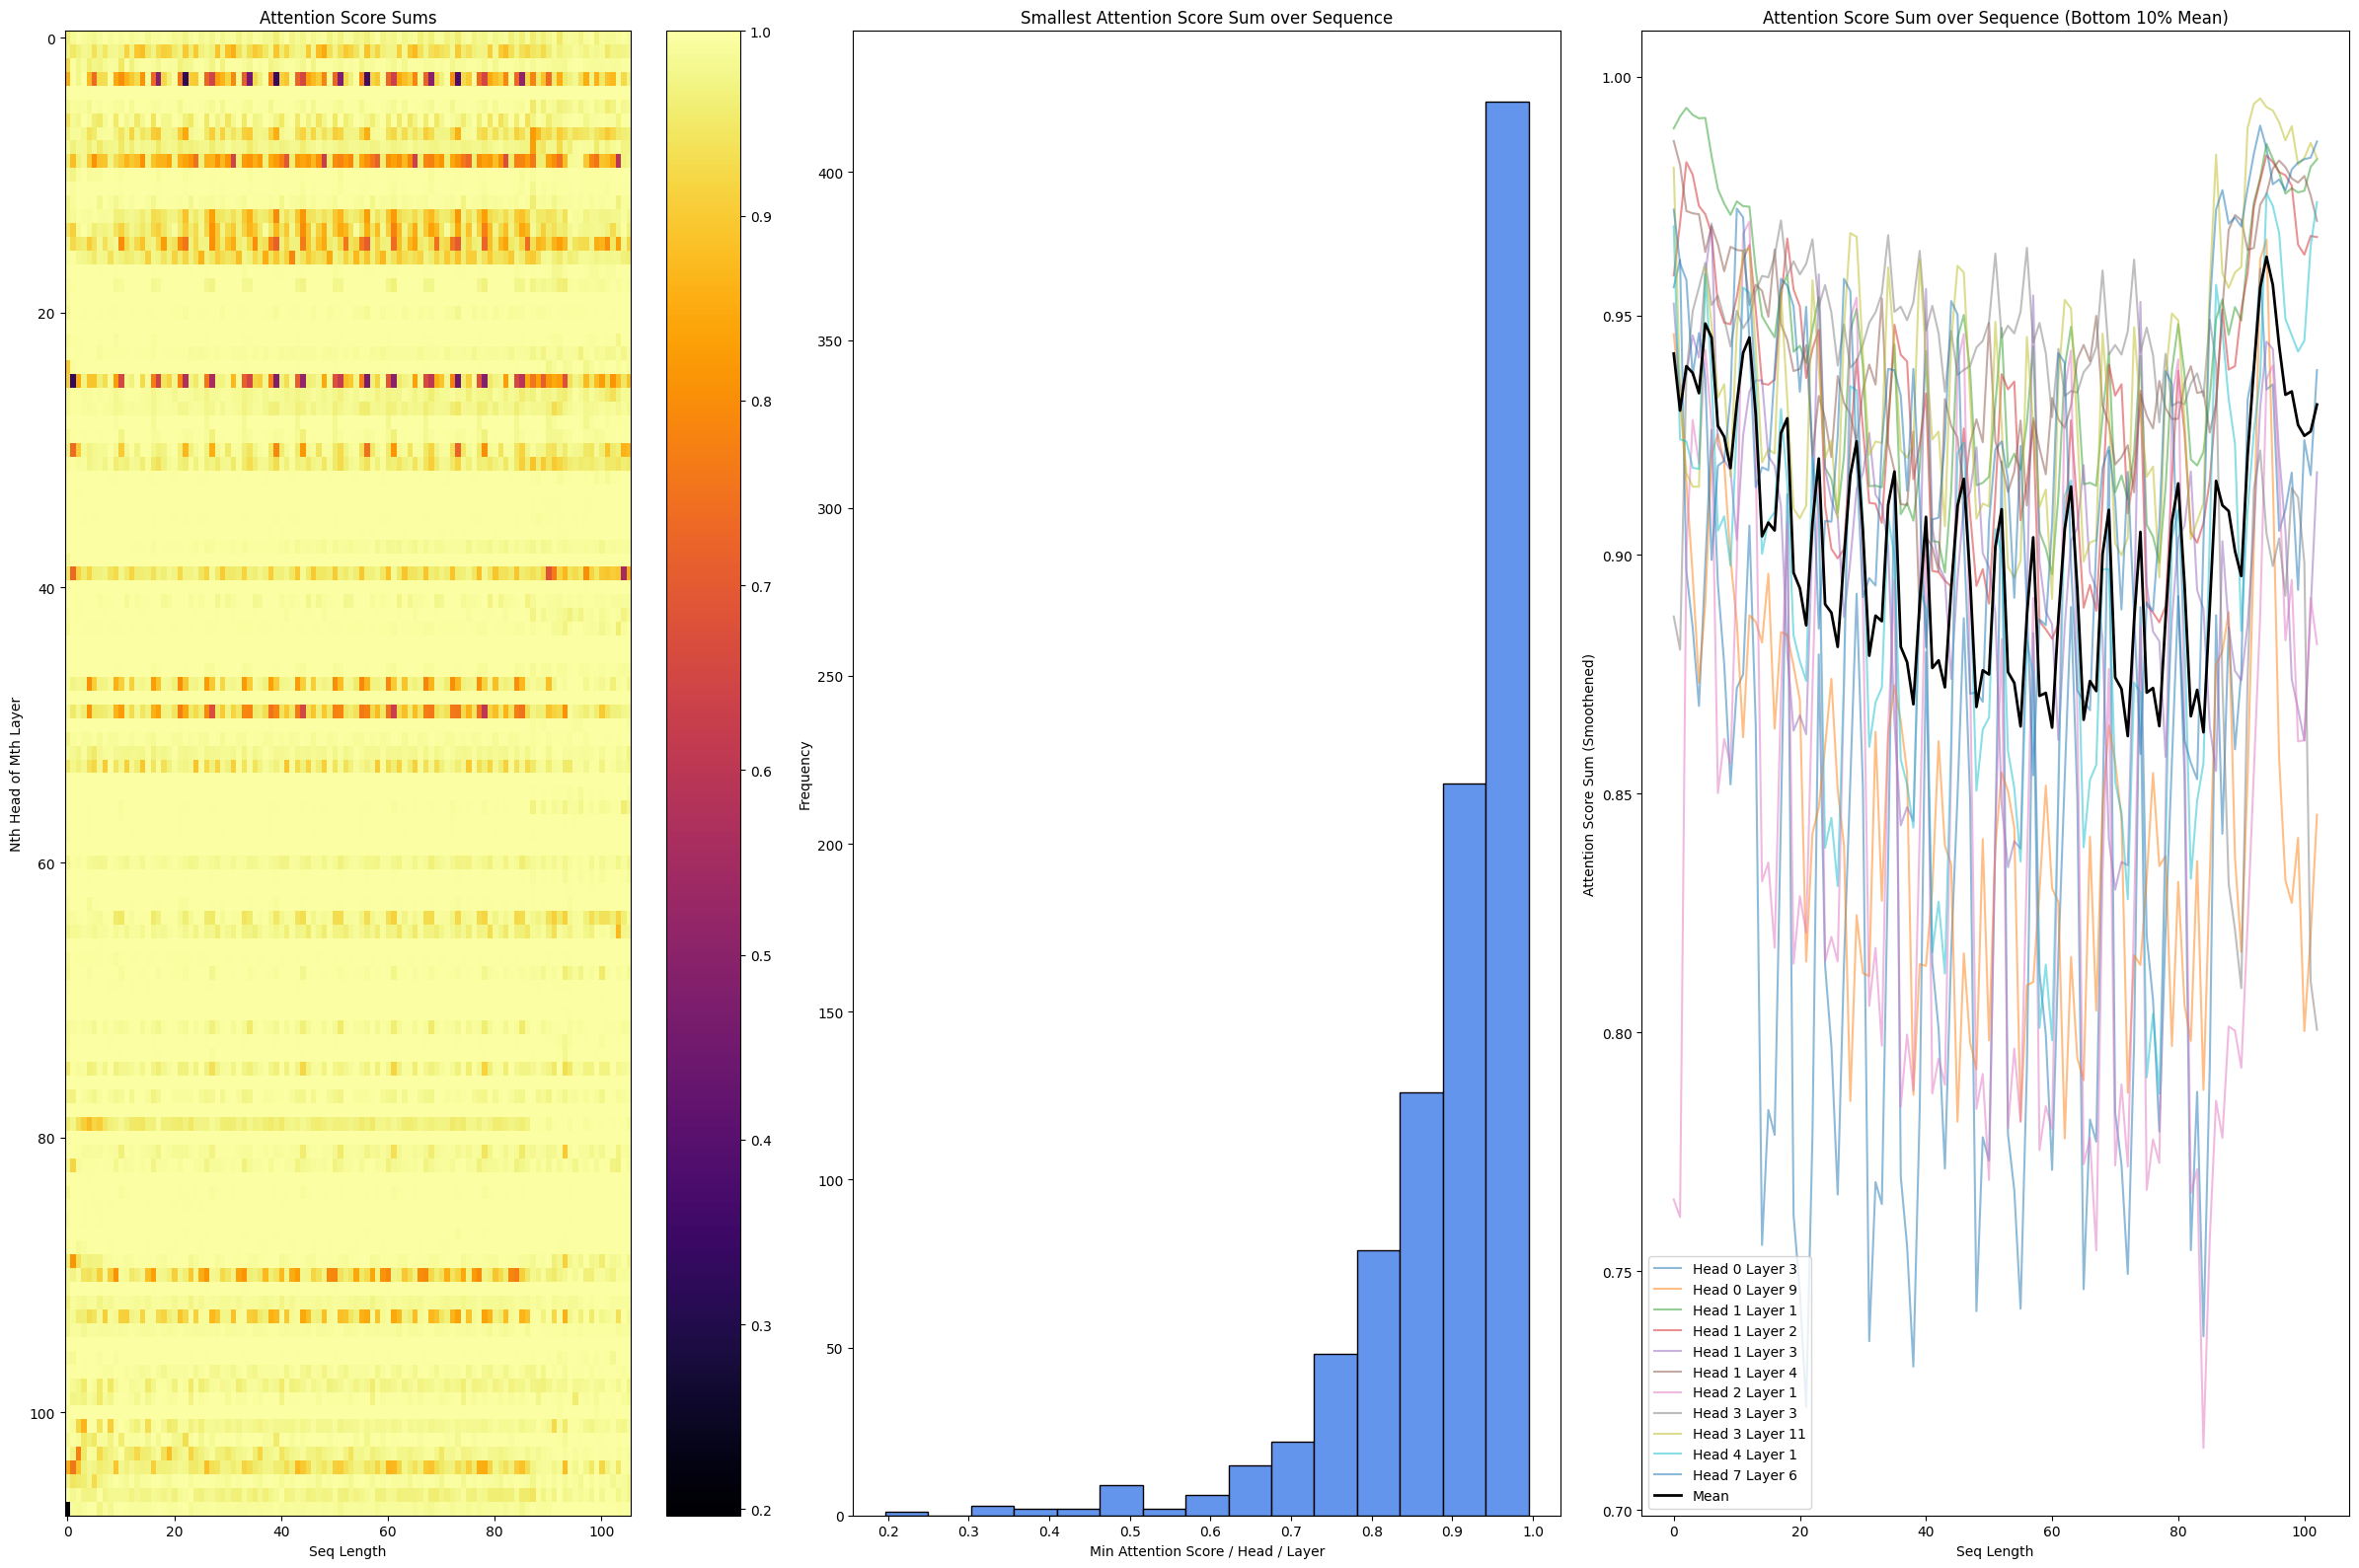

In [ ]:
prompt = " idjfkldsfj klsdjfkl sfj ksdf" * 5
max_new_tokens = 20

ppl = compute_perplexity(prompt, max_new_tokens=max_new_tokens)
print(generate(prompt=prompt, max_new_tokens=max_new_tokens))
from model import softmax_sum
S = torch.stack(softmax_sum)
print(S.shape)
print(f"Token Count: {S.shape[2]}")
print(f'Perplexity: {ppl:.4f}')
print(f"Overall Min: {S.min().item():.4f}")
display(interactive_attnsum_layer(S))
attnsum_all(S)

In [ ]:
import matplotlib.pyplot as plt

def plot_multi_scale_line_chart(timesteps, lists, list_labels, list_colors):
    """
    Plot multiple lists on the same line chart with their own scales.
    
    Args:
        timesteps (list): List of timesteps for the x-axis.
        lists (list of lists): List of data lists to be plotted.
        list_labels (list of str): List of labels for the data lists.
        list_colors (list of str): List of colors for the data lines.
    """
    # Create a figure and axis
    fig, ax1 = plt.subplots()

    # Loop through the lists and plot data on separate y-axes
    for i, (data, label, color) in enumerate(zip(lists, list_labels, list_colors)):
        ax = ax1 if i == 0 else ax1.twinx()  # Use the first y-axis for the first list

        ax.plot(timesteps, data, color=color, label=label)
        ax.set_ylabel(label, color=color)
        ax.tick_params(axis='y', labelcolor=color)
        ax.legend(loc='upper left' if i == 0 else 'upper right')

    # Adjust layout to prevent overlapping labels
    plt.tight_layout()
    plt.show()

def test_plot_multi_scale_line_chart():
    """Test the plot_multi_scale_line_chart function."""
    timesteps = list(range(5))  # Assuming lists are of the same length
    list1 = [10, 20, 30, 40, 50]
    list2 = [0.5, 1.5, 2.5, 3.5, 4.5]
    list3 = [100, 150, 200, 250, 300]
    lists = [list1, list2, list3]
    list_labels = ['List 1', 'List 2', 'List 3']
    list_colors = ['tab:blue', 'tab:orange', 'tab:green']

    plot_multi_scale_line_chart(timesteps, lists, list_labels, list_colors)

In [ ]:
from collections import defaultdict
from tqdm import tqdm

perplexity_ab_prompts = [
		# Preschool
		"Once upon a time,",
		"Lily loved to play",
		"Jack and Jill went up the hill,",
		"Bob saw the playground",
		"A long long time ago,",
		# 1st grade
		"Sunny the bear",
		"Lucy found a magic",
		"Timmy's pet frog",
		"Emily's first day at",
		"In a land of",
		# Middle school
		"Lost in a virtual",
		"Ella's science experiment went",
		"Enchanted forest appeared overnight,",
		"Robots gaining human emotions",
		"Alien communication through coded",
		# PhD
		"Revolutionizing quantum computing:",
		"Unraveling the complexities of",
		"Ethics in AI: Unveiling",
		"Galactic anomalies challenge astrophysicists",
		"Synthesizing novel compounds for",
		# Academia-speak
		"Transdimensional hyperflux in the metaquantum entanglement matrix",
		"Hyperdimensional hypercognition catalyzes the entanglement of metasemiotic",
		"Epistemological deconstruction of hypercontextual postulates deconstructs",
		"Nonlocal retrocausal quantum hermeneutics deconstruct spacetime's metanarrative",
		"Metasemiotic metamorphosis transmutes logocentric paradigms into kaleidoscopic",
		# SHA256 hashes
		"e3b0c44298fc1c149afbf4c",
		"cf83e1357eefb8bdf1542850",
		"b2f5ff47436671b6e533d8d",
		"da39a3ee5e6b4b0d3255b",
		"77de68daecd823babbb58e",
]

ppl_data = defaultdict(list)

print(f"Generating {len(perplexity_ab_prompts)} samples...")

for prompt in tqdm(perplexity_ab_prompts):
	ppl_data['ppl'].append(compute_perplexity(prompt))
	ppl_data['completion'].append(generate(prompt=prompt))
	from model import softmax_sum
	S = torch.stack(softmax_sum)
	ppl_data['count'].append(S.shape[2])
	ppl_data['min'].append(S.min().item())
	S_mean = S.flatten(0,1).mean(-1)
	ppl_data['S'].append(S_mean)

S = torch.stack(ppl_data['S'], dim=1)
print('\n'.join([f'- {s[:100]}' for s in ppl_data['completion']]))
attnsum_all(S)

# Sample data for demonstration
timesteps = list(range(len(ppl_data['count'])))  # Assuming lists are of the same length
lists = [ppl_data['count'], ppl_data['min'], ppl_data['ppl']]
list_labels = ['Token Count', 'Min Attention Score', 'Perplexity']
list_colors = ['tab:blue', 'tab:orange', 'tab:green']

# Call the function to plot the data
plot_multi_scale_line_chart(timesteps, lists, list_labels, list_colors)

Generating 30 samples...


 83%|████████▎ | 25/30 [01:16<00:15,  3.08s/it]


KeyboardInterrupt: 